Make a butler, but we don't point it at the usual repo root, we point it at the location of best reduction of the data to date.

In [1]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler('/project/shared/auxTel/rerun/mfl/binning4/')

Next, we make a NightReporter object. This is just a useful little toy project (read: not well supported, but might be helpful) to will help understand (and visualise) the night's observations. Try poking it to see what it does, some it it, _e.g._ reporter.printObsTable() is quite useful for getting a quick overview of the observations of the night.

In [2]:
from lsst.rapid.analysis.nightReport import NightReporter
repoDir = '/project/shared/auxTel/'
reporter = NightReporter(repoDir, "2020-03-12")

Loaded data for seqNums 1 to 378


In [3]:
dayObs = '2020-03-12'

In [4]:
%matplotlib inline

See what objects we looked at over the course of the selected dayObs, so that we can pick one that sampled a nice range of airmasses to examine further.

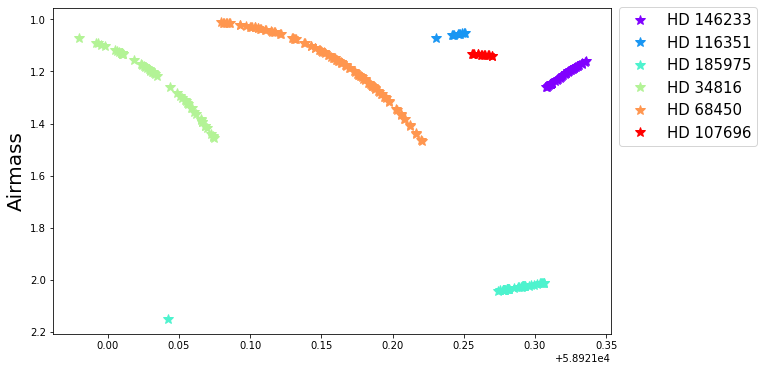

In [5]:
reporter.plotPerObjectAirMass()

In [6]:
objName = 'HD 34816'

Here we find out from the butler which sequence numbers are observations of that star. Note that a) some will be dispersed, but some will likely be direct images or donuts, etc, and that b) of the dispersed images, some might not have run all the way through the pipeline without failure, so we're going to need to test for that.

In [7]:
seqNums = butler.queryMetadata('raw', 'seqNum', dayObs=dayObs, object=objName)

Here, for the seqNums, we ask the butler to check if the output of Spectractor actually exists, such that it can be retrieved.

In [8]:
extracted = []
for seqNum in seqNums:
    if butler.datasetExists('spectraction', dayObs=dayObs, seqNum=seqNum):
        extracted.append(seqNum)

Grab a random single result just so we've got an object to poke at, such that we can use it to help us write the code that follows.

In [9]:
result = butler.get('spectraction', dict(dayObs=dayObs, seqNum=extracted[0]))

In [10]:
result.lsstExp.getInfo().getVisitInfo().getBoresightAirmass()

1.09943087907045

In [11]:
result.spectrum.header

TARGET  = 'HD 34816'           / name of the target in the image                
REDSHIFT= '6.7e-05 '           / redshift of the target                         
GRATING = 'ronchi90lpmm'       / name of the disperser                          
ROTANGLE=    -1.31846387073869 / [deg] angle of the dispersion axis             
D2CCD   =    174.8698647431189 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
TARGETX =    398.5849973583478 / target position on X axis                      
TARGETY =    378.0312140859302 / target position on Y axis                      
THETAFIT=    -1.31846387073869 / [deg] [USED] rotation angle from the Hessian an
THETAINT=                  0.0 / [deg] rotation angle interp from disperser scan
PSF_REG =    1.892343618644976                                                  
LBDA_REF=    567.9711701956317                                                  
PIXSHIFT= -0.008657001414360

Build a dictionary of all the results for our sequence numbers:

In [12]:
results = {}
for seqNum in extracted:
    results[seqNum] = butler.get('spectraction', dayObs=dayObs, seqNum=seqNum)

Pick a random extraction, grab its lines, and see what their names are

In [13]:
for lineNum, line in enumerate(result.spectrum.lines.lines):
    print(lineNum, line.label)

0 $Fe_{I}$
1 $Ca_{II}$
2 $Ca_{II}$
3 $H\epsilon$
4 $H\delta$
5 $Fe_{I}$
6 $H\gamma$
7 $Fe_{I}$
8 $H\beta$
9 $Mg_{I}$
10 $Mg_{I}$
11 $Fe_{I}$
12 $H\alpha$
13 $O_2(B)$
14 
15 $O_2$
16 $O_2(Z)$
17 $O_2(Y)$
18 $H_2 O$


Now that we've poked a line to see how it quacks, lets look over all the extractions, pull the O2 line out, and plot its equivalent width against airmass

In [14]:
airmasses, eqWidths = [], []
for seqNum in results.keys():
    airmass = results[seqNum].lsstExp.getInfo().getVisitInfo().getBoresightAirmass()
    line = [line for line in results[seqNum].spectrum.lines.lines if line.label=='$O_2$']
    eqWidth = line[0].fit_eqwidth_data
    airmasses.append(airmass)
    eqWidths.append(eqWidth)

In [15]:
import matplotlib.pyplot as plt

NB: This is a garbage in, garbage out situation. The current reductions are known-bad in many places, and this is just a toy example showing how one can access data, so don't freak out that it's bad!

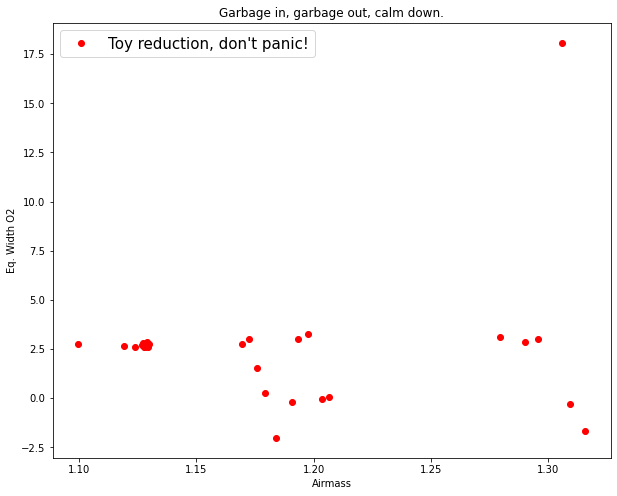

In [16]:
fig = plt.figure(figsize=(10, 8))
_ = plt.plot(airmasses, eqWidths, 'or', label="Toy reduction, don't panic!")
_ = plt.xlabel('Airmass')
_ = plt.ylabel('Eq. Width O2')
_ = plt.legend(fontsize=15)
_ = plt.title('Garbage in, garbage out, calm down.')